In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "5"

In [ ]:
from einops import rearrange
import math
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from bliss.encoders.detection import DetectionEncoder
from bliss.catalog import TileCatalog, FullCatalog

import sep_pjw as sep

from bliss.datasets.lsst import BACKGROUND

from torch import Tensor

from bliss.reporting import compute_tp_fp_per_bin

from bliss.datasets.lsst import convert_flux_to_mag, get_default_lsst_psf, get_default_lsst_background

from einops import rearrange

from bliss.datasets.generate_blends import render_full_catalog

In [ ]:
device = torch.device("cuda:0")


In [ ]:
# model
detection = DetectionEncoder().to(device).eval()
_ = detection.load_state_dict(
    torch.load(f"../../models/detection_42_42.pt", map_location=device, weights_only=True)
)
detection = detection.requires_grad_(False)

In [ ]:
slen = 44
bp = detection.bp
tile_slen = detection.tile_slen
size = slen + 2 * bp
tile_slen = detection.tile_slen
ptile_slen = detection.ptile_slen
assert slen / tile_slen % 2 == 1, "Need odd number of tiles to center galaxy."


In [ ]:

# now separations between galaxies to be considered (in pixels)
# for efficiency, we set the batch_size equal to the number of separations
seps = torch.arange(0, 18, 0.1)
batch_size = len(seps)

# first centered galaxy, then moving one.
colnames = (
    "fluxnorm_bulge",
    "fluxnorm_disk",
    "fluxnorm_agn",
    "a_b",
    "a_d",
    "b_b",
    "b_d",
    "pa_bulge",
    "i_ab",
    "flux",
)
assert len(colnames) == 10
n_sources = 2
flux1, flux2 = 1e6, 5e5
mag1, mag2 = convert_flux_to_mag(torch.tensor([flux1, flux2]))
mag1, mag2 = mag1.item(), mag2.item()
gparam1 = [0, 1.0, 0, 0, 1.5, 0, 0.7, 45, 45, mag1, flux1]
gparam2 = [0, 1.0, 0, 0, 1.0, 0, 0.7, 135, 135, mag2, flux2]
gparams = torch.tensor([gparam1, gparam2])
gparams = gparams.reshape(1, 2, 11).expand(batch_size, 2, 11)
print(f"INFO: Fluxes correspond to magnitudes ({mag1},{mag2})")

INFO: Fluxes correspond to magnitudes (22.13484764099121,22.887422561645508)


In [ ]:

# need plocs for later
x0, y0 = 22, 22  # center plocs
true_plocs = torch.tensor([[[x0, y0], [x0, y0 + sep]] for sep in seps]).reshape(batch_size, 2, 2)

psf = get_default_lsst_psf()
bg = get_default_lsst_background()

# create full catalogs (need separately since `render_blend`` only accepts 1 batch)
images = torch.zeros(batch_size, 1, size, size)
background = torch.full((batch_size, 1, size, size), bg)
noise = torch.randn_like(images[0]).reshape(1, 1, size, size) * np.sqrt(bg)

for ii in range(batch_size):
    plocs_ii = true_plocs[ii].reshape(1, 2, 2)
    d = {
        "n_sources": torch.full((1,), n_sources),
        "plocs": plocs_ii,
        "galaxy_bools": torch.ones(1, n_sources, 1),
        "galaxy_params": gparams[ii, None],
        "star_bools": torch.zeros(1, n_sources, 1),
        "star_fluxes": torch.zeros(1, n_sources, 1),
        "star_log_fluxes": torch.zeros(1, n_sources, 1),
    }
    full_cat = FullCatalog(slen, slen, d)
    image, _, _ = render_full_catalog(full_cat, psf, slen, bp)

    images[ii] = image + noise 

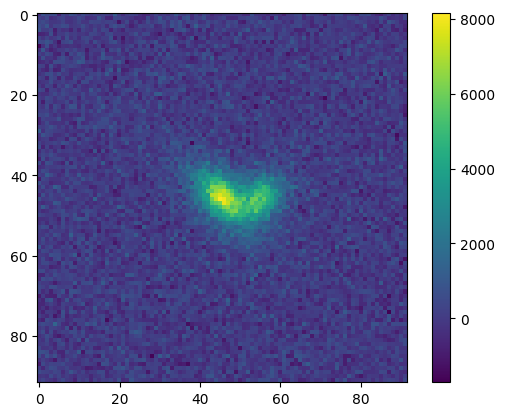

In [ ]:
plt.imshow(images[100, 0])
plt.colorbar()

In [ ]:
n_source_probs, locs_mean, locs_sd = detection.forward(images.to(device))

tile_params = TileCatalog.from_flat_dict(tile_slen, 11, 11, 
                                         {'n_source_probs': n_source_probs.reshape(-1, 1).to('cpu'), 'locs': locs_mean.to('cpu'), 'locs_sd':locs_sd.to('cpu'), 'n_sources':n_source_probs.ge(0.1).to('cpu')})
full_cat_params = tile_params.to_full_params()

In [ ]:
full_cat_params['n_source_probs'].shape

torch.Size([180, 5, 1])

In [ ]:
n_source_probs = full_cat_params['n_source_probs'][:, :, 0]
n_source_probs[100]

tensor([0.4065, 0.4886, 0.1440, 0.1209, 0.9562])

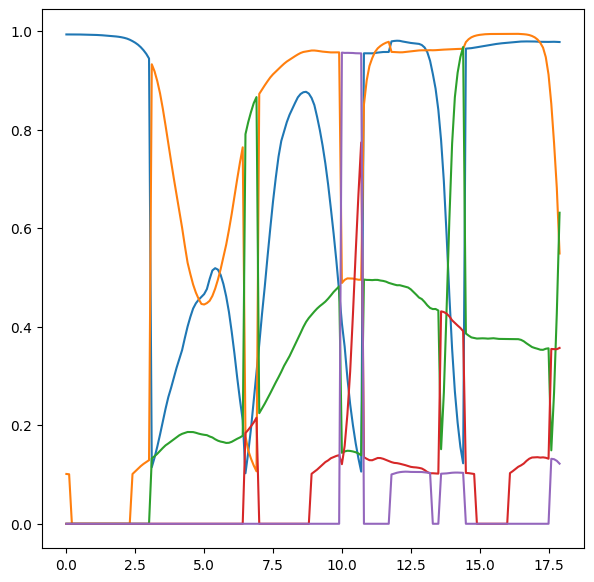

In [ ]:
plt.figure(figsize=(7,7))
n_source_probs = full_cat_params['n_source_probs'][:, :, 0]
for jj in range(5):
    probs = n_source_probs[:, jj]
    plt.plot(seps, probs)

In [ ]:
seps[50]

tensor(5.)

In [ ]:
# MAP
# do not include background!!!
tile_cat_map = detection.variational_mode(images.to(device)).to('cpu')
cat_map = tile_cat_map.to_full_params()

# never out of tile in MAP

In [ ]:
cat_map.n_sources

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3])

In [ ]:
samples = detection.sample(images.to(device), n_samples=100)
samples = {k:v.to('cpu') for k,v in samples.items()}

tensor([0.0519])


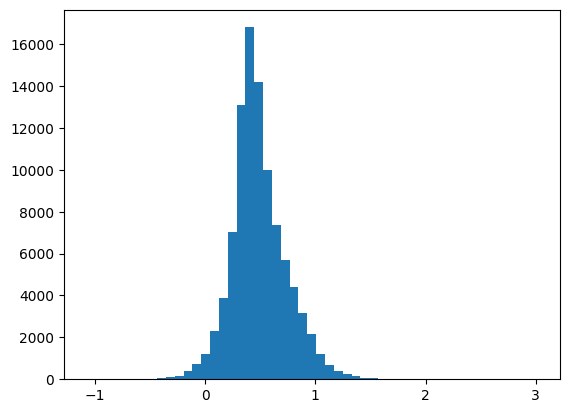

In [ ]:
# how many fall out of distribution??
_locs = samples['locs'].flatten()
nonzero_locs = _locs[_locs.nonzero()]

_ = plt.hist(nonzero_locs, bins=51)


total_out = sum(nonzero_locs < 0) + sum(nonzero_locs > 1)
print(total_out / len(nonzero_locs)) # ~ 5%


In [ ]:
# trim samples of locs with some tolerance
mask = samples['locs'] != 0.0
new_locs = samples['locs'].clamp(min=0.001, max=1.0-0.001) * mask.float()

In [ ]:
# # maask out samples out of boundaries
# mask_xy = samples['locs'].ge(0.001) * samples['locs'].le(1 - 0.001)
# mask = mask_xy[...,0].bitwise_and(mask_xy[...,1])
# samples['locs'] = samples['locs'] * rearrange(mask, 'n nt -> n nt 1')
# samples['n_sources'] = samples['n_sources'] * mask

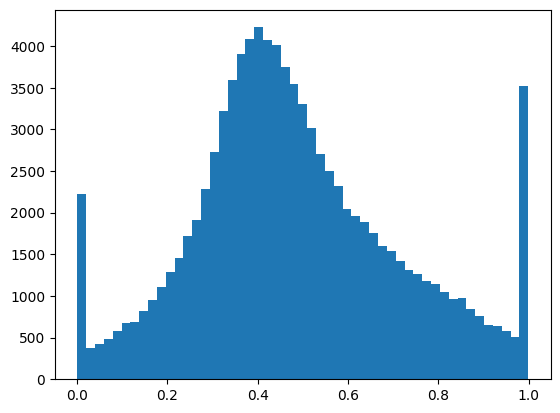

In [ ]:
_locs = new_locs.flatten()
nonzero_locs = _locs[_locs.nonzero()]

_ = plt.hist(nonzero_locs, bins=51)

In [ ]:
new_samples = {**samples}
new_samples['locs'] = new_locs

In [ ]:
# get catalogs
tile_cats = [] 
cats = [] 
n_samples = 100
for ii in range(n_samples): 
    tile_cat = TileCatalog.from_flat_dict(tile_slen, 11, 11, {k:v[ii] 
                                                              for k,v in new_samples.items()})
    cat = tile_cat.to_full_params()
    cats.append(cat)

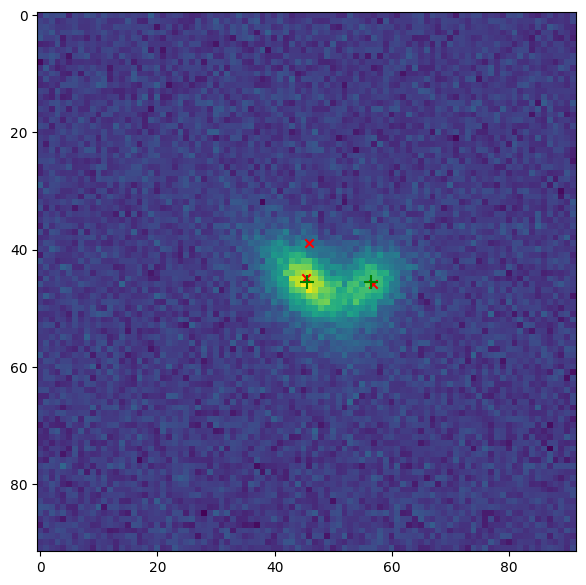

In [ ]:
plt.figure(figsize=(7,7))

ii = 110
jj = np.random.randint(0, 100)
plt.imshow(images[ii, 0])

_plocs = cats[jj].plocs
for kk in range(len(_plocs[ii])):
    x, y = _plocs[ii, kk, 1].item(), _plocs[ii, kk, 0].item()
    if x > 0 and y > 0:
        plt.scatter(x+bp-0.5, y+bp-0.5, marker='x', color='r')

plt.scatter(true_plocs[ii, :, 1] + bp - 0.5, true_plocs[ii, :, 0] + bp - 0.5, marker='+', color='g', s=100, )

In [ ]:
images.shape

torch.Size([180, 1, 92, 92])

In [ ]:
slen

44

In [ ]:
# now use deblender to obtain reconstructions  and corresponding aperture photometry (for each sample!)
from bliss.encoders.deblend import GalaxyEncoder
deblend_fpath = "../../models/deblender_42_42.pt"
ae_fpath = "../../models/autoencoder_42_42.pt"

deblender = GalaxyEncoder(ae_fpath)
deblender.load_state_dict(torch.load(deblend_fpath, map_location=device, weights_only=True))
deblender = deblender.requires_grad_(False).to(device)

In [ ]:
images.device

device(type='cpu')

In [ ]:
images.shape

torch.Size([180, 1, 92, 92])

In [ ]:
deblender.variational_mode(images.to(device), tile_locs).shape

torch.Size([180, 11, 11, 8])

In [ ]:
new_cat.batch_size

180

In [ ]:
fluxes.shape

torch.Size([180, 5, 1])

In [ ]:
# we need to do some sort of matching for the galaxy we are targeting

from bliss.reporting import get_deblended_reconstructions, get_fluxes_sep
from bliss.catalog import get_is_on_from_n_sources


all_fluxes = []
for cat in tqdm(cats[:10], total=len(cats[:10])): 

     tile_cat = cat.to_tile_params(tile_slen)
     tile_cat['galaxy_bools'] = rearrange(tile_cat.n_sources, 'b x y -> b x y 1')
     tile_locs = tile_cat.locs.to(device)
     _tile_gparams = deblender.variational_mode(images.to(device), tile_locs).to("cpu")
     _tile_gparams *= tile_cat['galaxy_bools']
     tile_cat['galaxy_params'] = _tile_gparams
     new_cat = tile_cat.to_full_params()

     recon_uncentered = get_deblended_reconstructions(new_cat, deblender._dec, 
                                                      slen=slen, device=deblender.device, batch_size=200)
     fluxes, _, _ = get_fluxes_sep(new_cat, images, 
                                   paddings=torch.zeros_like(images), sources=recon_uncentered,  )
     all_fluxes.append(fluxes)

max_n_fluxes = max(f.shape[1] for f in fluxes)
all_the_fluxes = torch.zeros(100, 180, max_n_fluxes, 1)
for ii, fs in enumerate(fluxes):
     all_the_fluxes[]


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:34<00:00,  3.47s/it]


RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 6 but got size 8 for tensor number 3 in the list.

In [ ]:
# need to organize fluxes by closest to plocs

In [ ]:
cats[0].to_tile_params(tile_slen, ignore_extra_sources=False)

{}

In [ ]:
cats[0]['galaxy_bools']

KeyError: 'galaxy_bools'